In [76]:
import numpy as np
from numpy import pi

# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, assemble, Aer, IBMQ, execute
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_bloch_multivector, plot_histogram

import numpy as np
from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import Kraus, SuperOp
from qiskit.providers.aer import AerSimulator
from qiskit.tools.visualization import plot_histogram

# Import from Qiskit Aer noise module
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise import QuantumError, ReadoutError
from qiskit.providers.aer.noise import pauli_error
from qiskit.providers.aer.noise import depolarizing_error
from qiskit.providers.aer.noise import thermal_relaxation_error

# Single qubit measurement with no noise

In [77]:
# single qubit circuit
# initially the state of qubit is 0

qc0 = QuantumCircuit(1,1)
qc0.draw()


q: 
     
c: 1/

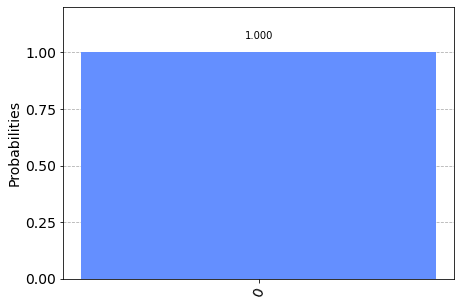

In [78]:
qc0.measure(0,0)
backend = Aer.get_backend('qasm_simulator') # we choose the simulator as our backend
counts = execute(qc0, backend, shots = 1000).result().get_counts() # we run the simulation and get the counts
plot_histogram(counts)

# Adding bit-flip noise channel

In [79]:
#building a noisy bit flip channel

qc= QuantumCircuit(1,1)
qc.x(0)
p_gate1 = 0.1  #bit flip probability

# QuantumError objects

error_gate1 = pauli_error([('X',1-p_gate1), ('I', p_gate1)])


# Add errors to noise model
noise_bit_flip = NoiseModel()

noise_bit_flip.add_all_qubit_quantum_error(error_gate1, ["u1", "u2", "u3"])
print(noise_bit_flip)

NoiseModel:
  Basis gates: ['cx', 'id', 'rz', 'sx', 'u1', 'u2', 'u3']
  Instructions with noise: ['u1', 'u3', 'u2']
  All-qubits errors: ['u1', 'u2', 'u3']


In [80]:

qc.measure([0],[0])
sim_noise = AerSimulator(noise_model=noise_bit_flip)

# Transpile circuit for noisy basis gates
circ_tnoise = transpile(qc, sim_noise)
circ_tnoise.draw()
# Run and get counts
#result_bit_flip = sim_noise.run(circ_tnoise).result()
#counts_bit_flip = result_bit_flip.get_counts(0)

# Plot noisy output
#plot_histogram(counts_bit_flip)

┌────────────┐┌─┐
  q: ┤ U3(π,0,-π) ├┤M├
     └────────────┘└╥┘
c: 1/═══════════════╩═
                    0

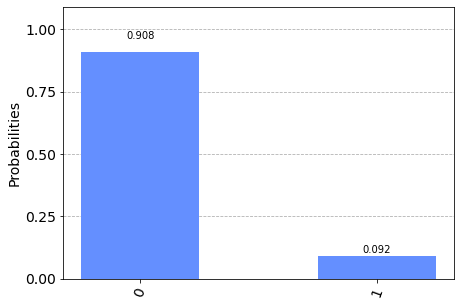

In [81]:
result_bit_flip = sim_noise.run(circ_tnoise).result()
counts_bit_flip = result_bit_flip.get_counts(0)

plot_histogram(counts_bit_flip)

In [82]:
counts = result_bit_flip.get_counts(qc)
c1=counts['1']
c0=1024-c1
exp =(c1/1024)*100
theo=(p_gate1)*100
print("\nno. of counts of no bit flip:",c0)
print("no. of counts of bit flip:",c1)
print("\nexperimental error(%)=",exp,'%')
print("theoretical error(%)=",theo,'%')


no. of counts of no bit flip: 930
no. of counts of bit flip: 94

experimental error(%)= 9.1796875 %
theoretical error(%)= 10.0 %


# Error Correction Code

In [83]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit

#encoding qubit in 3 qubits
#note-4th and 5th qubits are the ancillary qubits and 1st qubit(q_0) is the test qubit


q = QuantumRegister(5, 'q')
c=ClassicalRegister(5,'c')

qc1=QuantumCircuit(q,c)
qc1.cx(0,1)
qc1.cx(0,2)

qc1.draw()

q_0: ──■────■──
     ┌─┴─┐  │  
q_1: ┤ X ├──┼──
     └───┘┌─┴─┐
q_2: ─────┤ X ├
          └───┘
q_3: ──────────
               
q_4: ──────────
               
c: 5/══════════

In [84]:
#Adding noisy bit flip channels

qc2=QuantumCircuit(q,c)
qc2.x(0)
qc2.x(1)
qc2.x(2)
sim_noise = AerSimulator(noise_model=noise_bit_flip)

# Transpile circuit for noisy basis gates
circ_tnoise = transpile(qc2, sim_noise)
circ_tnoise.draw()

┌────────────┐
q_0: ┤ U3(π,0,-π) ├
     ├────────────┤
q_1: ┤ U3(π,0,-π) ├
     ├────────────┤
q_2: ┤ U3(π,0,-π) ├
     └────────────┘
q_3: ──────────────
                   
q_4: ──────────────
                   
c: 5/══════════════

In [85]:
from qiskit.circuit import QuantumCircuit, Qubit, Clbit

#error syndrome detection

qc3=QuantumCircuit(q,c)
qc3.cx(0,3)
qc3.cx(1,3)
qc3.cx(0,4)
qc3.cx(2,4)

qc3.measure([3,4],[3,4])
qc3.x(q[2]).c_if(c,16)
qc3.x(q[1]).c_if(c,8)
qc3.x(q[0]).c_if(c,24)
qc3.draw()

┌───┐  
q_0: ──■─────────■─────────────────────────────┤ X ├──
       │         │                      ┌───┐  └─╥─┘  
q_1: ──┼────■────┼──────────────────────┤ X ├────╫────
       │    │    │              ┌───┐   └─╥─┘    ║    
q_2: ──┼────┼────┼────■─────────┤ X ├─────╫──────╫────
     ┌─┴─┐┌─┴─┐  │    │  ┌─┐    └─╥─┘     ║      ║    
q_3: ┤ X ├┤ X ├──┼────┼──┤M├──────╫───────╫──────╫────
     └───┘└───┘┌─┴─┐┌─┴─┐└╥┘┌─┐   ║       ║      ║    
q_4: ──────────┤ X ├┤ X ├─╫─┤M├───╫───────╫──────╫────
               └───┘└───┘ ║ └╥┘┌──╨───┐┌──╨──┐┌──╨───┐
c: 5/═════════════════════╩══╩═╡ 0x10 ╞╡ 0x8 ╞╡ 0x18 ╞
                          3  4 └──────┘└─────┘└──────┘

In [86]:
#decoding the 3 qubits

qc4=QuantumCircuit(q,c)
qc4.cx(0,1)
qc4.cx(0,2)

In [87]:
#Full circuit of bit 3-qubit bit flip correction

qc5=qc1+circ_tnoise+qc3+qc4
qc5.draw()

C:\Users\prate\AppData\Local\Temp\ipykernel_69532\3789997989.py:3: DeprecationWarning: The QuantumCircuit.__add__() method is being deprecated.Use the compose() method which is more flexible w.r.t circuit register compatibility.
  qc5=qc1+circ_tnoise+qc3+qc4


┌────────────┐                                          ┌───┐  »
q_0: ──■────■──┤ U3(π,0,-π) ├──■─────────■─────────────────────────────┤ X ├──»
     ┌─┴─┐  │  ├────────────┤  │         │                      ┌───┐  └─╥─┘  »
q_1: ┤ X ├──┼──┤ U3(π,0,-π) ├──┼────■────┼──────────────────────┤ X ├────╫────»
     └───┘┌─┴─┐├────────────┤  │    │    │              ┌───┐   └─╥─┘    ║    »
q_2: ─────┤ X ├┤ U3(π,0,-π) ├──┼────┼────┼────■─────────┤ X ├─────╫──────╫────»
          └───┘└────────────┘┌─┴─┐┌─┴─┐  │    │  ┌─┐    └─╥─┘     ║      ║    »
q_3: ────────────────────────┤ X ├┤ X ├──┼────┼──┤M├──────╫───────╫──────╫────»
                             └───┘└───┘┌─┴─┐┌─┴─┐└╥┘┌─┐   ║       ║      ║    »
q_4: ──────────────────────────────────┤ X ├┤ X ├─╫─┤M├───╫───────╫──────╫────»
                                       └───┘└───┘ ║ └╥┘┌──╨───┐┌──╨──┐┌──╨───┐»
c: 5/═════════════════════════════════════════════╩══╩═╡ 0x10 ╞╡ 0x8 ╞╡ 0x18 ╞»
                                                  3  4 └──────┘└─────┘└──────┘»
«               
«q_0: ──■────■──
«     ┌─┴─┐  │  
«q_1: ┤ X ├──┼──
«     └───┘┌─┴─┐
«q_2: ─────┤ X ├
«          └───┘
«q_3: ──────────
«               
«q_4: ──────────
«               
«c: 5/══════════
«

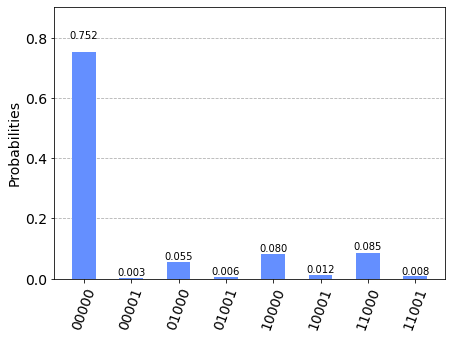

In [88]:
qc5.measure([0,1,2,3,4],[0,1,2,3,4])
sim_noise = AerSimulator(noise_model=noise_bit_flip)

# Transpile circuit for noisy basis gates

result_bit_flip = sim_noise.run(qc5).result()
counts_bit_flip = result_bit_flip.get_counts(0)

plot_histogram(counts_bit_flip)
#last qubit is the test qubit

In [89]:
counts = result_bit_flip.get_counts(qc5)
print("counts of each state after 1024 shots",counts)
if '00001' in counts:
 c1=counts['11001']+counts['01001']+counts['10001']+counts['00001']
else:
    c1=counts['11001']+counts['01001']+counts['10001']
#c1 tells the total counts of the states where the last qubit is 1(bit flip)
#c0 tells the total counts of the states where the last qubit is 0(no bit flip)
#if else conditions have been added because sometimes '00001' is not in histogram
c0=1024-c1
print("\nno. of counts of no bit flip:",c0)
print("no. of counts of bit flip:",c1)


counts of each state after 1024 shots {'10001': 12, '11001': 8, '01000': 56, '00000': 770, '00001': 3, '10000': 82, '01001': 6, '11000': 87}

no. of counts of no bit flip: 995
no. of counts of bit flip: 29


In [90]:
exp =(c1/1024)*100
theo=(3*(p_gate1)**(2)-2*(p_gate1)**(3))*100
print("experimental error(%)=",exp,'%')
print("theoretical error(%)=",theo,'%')

experimental error(%)= 2.83203125 %
theoretical error(%)= 2.8000000000000003 %
